# Creating TFRecords

**Author:** [Dimitre Oliveira](https://www.linkedin.com/in/dimitre-oliveira-7a1a0113a/)<br>
**Date created:** 2021/02/27<br>
**Last modified:** 2021/02/27<br>
**Description:** Converting data to the TFRecord format.

## Introduction

The TFRecord format is a simple format for storing a sequence of binary records.
Converting your data into TFRecord has many advantages, such as:

- **More efficient storage**: the TFRecord data can take up less space than the original
data; it can also be partitioned into multiple files.
- **Fast I/O**: the TFRecord format can be read with parallel I/O operations, which is
useful for [TPUs](https://www.tensorflow.org/guide/tpu) or multiple hosts.
- **Self-contained files**: the TFRecord data can be read from a single source—for
example, the [COCO2017](https://cocodataset.org/) dataset originally stores data in
two folders ("images" and "annotations").

An important use case of the TFRecord data format  is training on TPUs. First, TPUs are
fast enough to benefit from optimized I/O operations. In addition, TPUs require
data to be stored remotely (e.g. on Google Cloud Storage) and using the TFRecord format
makes it easier to load the data without batch-downloading.

Performance using the TFRecord format can be further improved if you also use
it with the [tf.data](https://www.tensorflow.org/guide/data) API.

In this example you will learn how to convert data of different types (image, text, and
numeric) into TFRecord.

**Reference**

- [TFRecord and tf.train.Example](https://www.tensorflow.org/tutorials/load_data/tfrecord)


## Dependencies

In [2]:
import os
import json
import pprint
import tensorflow as tf
import matplotlib.pyplot as plt

## Download the COCO2017 dataset

We will be using the [COCO2017](https://cocodataset.org/) dataset, because it has many
different types of features, including images, floating point data, and lists.
It will serve as a good example of how to encode different features into the TFRecord
format.

This dataset has two sets of fields: images and annotation meta-data.

The images are a collection of JPG files and the meta-data are stored in a JSON file
which, according to the [official site](https://cocodataset.org/#format-data),
contains the following properties:

```
id: int,
image_id: int,
category_id: int,
segmentation: RLE or [polygon], object segmentation mask
bbox: [x,y,width,height], object bounding box coordinates
area: float, area of the bounding box
iscrowd: 0 or 1, is single object or a collection
```

In [3]:
root_dir = "/home/suphale/snehal_bucket/coco/raw-data"
tfrecords_dir = "tfrecords"
images_dir = os.path.join(root_dir, "val2017")
annotations_dir = os.path.join(root_dir, "annotations")
annotation_file = os.path.join(annotations_dir, "instances_val2017.json")
images_url = "http://images.cocodataset.org/zips/val2017.zip"
annotations_url = (
    "http://images.cocodataset.org/annotations/annotations_trainval2017.zip"
)

# Download image files
if not os.path.exists(images_dir):
    image_zip = tf.keras.utils.get_file(
        "images.zip", cache_dir=os.path.abspath("."), origin=images_url, extract=True,
    )
    os.remove(image_zip)

# Download caption annotation files
if not os.path.exists(annotations_dir):
    annotation_zip = tf.keras.utils.get_file(
        "captions.zip",
        cache_dir=os.path.abspath("."),
        origin=annotations_url,
        extract=True,
    )
    os.remove(annotation_zip)

print("The COCO dataset has been downloaded and extracted successfully.")

with open(annotation_file, "r") as f:
    annotations = json.load(f)["annotations"]

print(f"Number of images: {len(annotations)}")

The COCO dataset has been downloaded and extracted successfully.
Number of images: 36781


### Contents of the COCO2017 dataset

In [4]:
pprint.pprint(annotations[60])

{'area': 367.89710000000014,
 'bbox': [265.67, 222.31, 26.48, 14.71],
 'category_id': 72,
 'id': 34096,
 'image_id': 525083,
 'iscrowd': 0,
 'segmentation': [[267.51,
                   222.31,
                   292.15,
                   222.31,
                   291.05,
                   237.02,
                   265.67,
                   237.02]]}


## Parameters

`num_samples` is the number of data samples on each TFRecord file.

`num_tfrecods` is total number of TFRecords that we will create.

In [5]:
num_samples = 4096
num_tfrecods = len(annotations) // num_samples
if len(annotations) % num_samples:
    num_tfrecods += 1  # add one record if there are any remaining samples

if not os.path.exists(tfrecords_dir):
    os.makedirs(tfrecords_dir)  # creating TFRecords output folder

In [6]:
split_layer = 100
saved_model_path = '/home/suphale/WorkSpace/saved_model'
model_path = saved_model_path + '/iv3_head_model_%d' % (split_layer)
head_model = tf.keras.models.load_model(model_path, compile=False)

model_path = saved_model_path + '/iv3_tail_model_%d' % (split_layer)
tail_model = tf.keras.models.load_model(model_path, compile=False)

## Define TFRecords helper functions

In [7]:

def image_feature(value):
    """Returns a bytes_list from a string / byte."""
    return tf.train.Feature(
        bytes_list=tf.train.BytesList(value=[tf.io.encode_jpeg(value).numpy()])
    )

def tensor_feature(value):
    """Returns a bytes_list from a string / byte."""
    return tf.train.Feature(
        bytes_list=tf.train.BytesList(value=[value.numpy().tobytes()])
    )

def bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value.encode()]))


def float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))


def int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))


def float_feature_list(value):
    """Returns a list of float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))


def create_example(image, path, example,h):
    feature = {
        "image": image_feature(image),
        "tensor": tensor_feature(h),
        "path": bytes_feature(path),
        "area": float_feature(example["area"]),
        "bbox": float_feature_list(example["bbox"]),
        "category_id": int64_feature(example["category_id"]),
        "id": int64_feature(example["id"]),
        "image_id": int64_feature(example["image_id"]),
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))


def parse_tfrecord_fn(example):
    feature_description = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "tensor": tf.io.FixedLenFeature([], tf.string),
        "path": tf.io.FixedLenFeature([], tf.string),
        "area": tf.io.FixedLenFeature([], tf.float32),
        "bbox": tf.io.VarLenFeature(tf.float32),
        "category_id": tf.io.FixedLenFeature([], tf.int64),
        "id": tf.io.FixedLenFeature([], tf.int64),
        "image_id": tf.io.FixedLenFeature([], tf.int64),
    }
    example = tf.io.parse_single_example(example, feature_description)
    example["image"] = tf.io.decode_jpeg(example["image"], channels=3)
    example["bbox"] = tf.sparse.to_dense(example["bbox"])
    return example


## Generate data in the TFRecord format

Let's generate the COCO2017 data in the TFRecord format. The format will be
`file_{number}.tfrec` (this is optional, but including the number sequences in the file
names can make counting easier).

In [8]:
num_tfrecods

9

In [9]:
from tqdm import tqdm

# num_tfrecods = 1
if(False):
    for tfrec_num in range(num_tfrecods):
        samples = annotations[(tfrec_num * num_samples) : ((tfrec_num + 1) * num_samples)]

        with tf.io.TFRecordWriter(
            tfrecords_dir + "/file_%.2i-%i.tfrec" % (tfrec_num, len(samples))
        ) as writer:
            for sample in tqdm(samples):
                image_path = f"{images_dir}/{sample['image_id']:012d}.jpg"
                image = tf.io.decode_jpeg(tf.io.read_file(image_path), channels=3)
                batch_image = tf.image.resize(image, (250, 250))
                batch_image = tf.expand_dims(batch_image, 0) 
                h = head_model(batch_image)
                example = create_example(image, image_path, sample,h)
                writer.write(example.SerializeToString())

In [35]:
image = tf.io.decode_jpeg(tf.io.read_file('/home/suphale/snehal_bucket/coco/raw-data/val2017/000000403353.jpg'),channels=3)
image = tf.image.resize(image, (250, 250))
tf.shape(image)

<tf.Tensor: shape=(3,), dtype=int32, numpy=array([250, 250,   3], dtype=int32)>

In [36]:
batch_image = tf.expand_dims(image, 0) 
h = head_model(batch_image)
tf.shape(h)

<tf.Tensor: shape=(4,), dtype=int32, numpy=array([  1,  13,  13, 768], dtype=int32)>

In [37]:
generated_image = tf.reshape(h, [  1  ,13,  13, 768])
# image_tensor = tf.convert_to_tensor(generated_image_np_array, dtype=tf.int32)

In [43]:
import numpy as np
from   numpy import float32
from   numpy import byte

print(tf.shape(h))
bytes_list=h.numpy().tobytes()
print(type(bytes_list))
# h_new = tf.reshape(bytes_list,[  1  ,13,  13, 768])
# b = tf.io.decode_raw(bytes_list, tf.int32)
# h_tensor = tf.Tensor(bytes_list)
# h_new = tf.reshape(b,[  1  ,28,  38, 768])
# print(tf.shape(h_new))

dr = tf.io.decode_raw(bytes_list, tf.int32)

# generated_np_array = np.frombuffer(bytes_list, dtype=np.int32)
# generated_image_np_array = generated_np_array.reshape([  1  ,13,  13, 768])
# image_tensor = tf.convert_to_tensor(generated_image_np_array, dtype=tf.int32)
# print(tf.shape(h))
dr = tf.reshape(dr, [  1,  13,  13, 768])
print(tf.shape(dr))

tf.Tensor([  1  13  13 768], shape=(4,), dtype=int32)
<class 'bytes'>
tf.Tensor([  1  13  13 768], shape=(4,), dtype=int32)


## Explore one sample from the generated TFRecord

In [28]:
print(num_samples)
raw_dataset = tf.data.TFRecordDataset(f"{tfrecords_dir}/file_00-{num_samples}.tfrec")
parsed_dataset = raw_dataset.map(parse_tfrecord_fn)
test_bytes = None
for features in parsed_dataset.take(1):
    for key in features.keys():
        if key != "image" and key != "tensor":
            print(f"{key}: {features[key]}")

    print(f"Image shape: {features['image'].shape}")
    print(f"Tensor shape: {features['tensor'].shape}")
    print(tf.shape(features["tensor"].numpy()))
    test_bytes = features["tensor"]
    bytes_list = features["tensor"].numpy()
    print(len(bytes_list))
    generated_np_array = np.frombuffer(bytes_list, dtype=np.int32)
    generated_image_np_array = generated_np_array.reshape([  1  ,13,  13, 768])
    image_tensor = tf.convert_to_tensor(generated_image_np_array, dtype=tf.int32)

#     h_new = tf.reshape(bytes_list,[  1  ,28,  38, 768])
    
#     h_tensor = tf.Tensor(bytes_list)
#     h_new = tf.reshape(bytes_list,[  1  ,28,  38, 768])

#     plt.figure(figsize=(7, 7))
#     plt.imshow(features["image"].numpy())
#     plt.show()

4096
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
bbox: [473.07 395.93  38.65  28.67]
area: 702.1057739257812
category_id: 18
id: 1768
image_id: 289343
path: b'datasets/val2017/000000289343.jpg'
Image shape: (640, 529, 3)
Tensor shape: ()
tf.Tensor([], shape=(0,), dtype=int32)
519168


In [17]:
type(test_bytes)

tensorflow.python.framework.ops.EagerTensor

bbox: [473.07 395.93  38.65  28.67]
area: 702.1057739257812
category_id: 18
id: 1768
image_id: 289343
path: b'datasets/val2017/000000289343.jpg'
Image shape: (640, 529, 3)
Tensor shape: ()


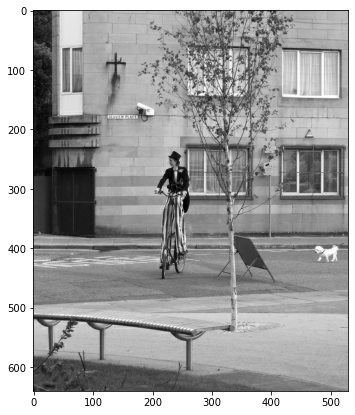

In [29]:
raw_dataset = tf.data.TFRecordDataset(f"{tfrecords_dir}/file_00-{num_samples}.tfrec")
parsed_dataset = raw_dataset.map(parse_tfrecord_fn)

for features in parsed_dataset.take(1):
    for key in features.keys():
        if key != "image" and key != "tensor":
            print(f"{key}: {features[key]}")

    print(f"Image shape: {features['image'].shape}")
    print(f"Tensor shape: {features['tensor'].shape}")
#     print(len(features["tensor"].numpy()))
#     print(type(features["tensor"]))
#     h = 
    
#     new_tensor = tf.reshape(features["tensor"].numpy(),[  1  ,28,  38, 768])
    plt.figure(figsize=(7, 7))
    plt.imshow(features["image"].numpy())
    plt.show()

## Train a simple model using the generated TFRecords

Another advantage of TFRecord is that you are able to add many features to it and later
use only a few of them, in this case, we are going to use only `image` and `category_id`.

## Define dataset helper functions

In [49]:

# def prepare_sample(features):
#     image = tf.image.resize(features["image"], size=(224, 224))
#     return image, features["category_id"]
def prepare_sample(features):
    # bytes_list = features["tensor"].numpy()
    # print(len(bytes_list))
    # generated_np_array = np.frombuffer(bytes_list, dtype=np.int32)
    # generated_image_np_array = generated_np_array.reshape([  1  ,13,  13, 768])
    # image_tensor = tf.convert_to_tensor(generated_image_np_array, dtype=tf.int32)
    bytes_list = features["tensor"]
    # tf.print(tf.shape(bytes_list))
    # tf.print(tf.size(bytes_list))
    dr = tf.io.decode_raw(bytes_list, tf.int32)
    # tf.print(tf.shape(dr))
    image_tensor = tf.reshape(dr, [  1,  13,  13, 768])
    # print(len(bytes_list))
    # generated_np_array = np.frombuffer(bytes_list, dtype=np.int32)
    # generated_image_np_array = tf.reshape(features["tensor"], [  1  ,13,  13, 768])
    # image_tensor = tf.convert_to_tensor(generated_image_np_array, dtype=tf.int32)
    return image_tensor, image_tensor


def get_dataset(filenames, batch_size):
    dataset = (
        tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTOTUNE)
        .map(parse_tfrecord_fn, num_parallel_calls=AUTOTUNE)
        .map(prepare_sample, num_parallel_calls=AUTOTUNE)
        .shuffle(batch_size * 10)
        .batch(batch_size)
        .prefetch(AUTOTUNE)
    )
    return dataset


train_filenames = tf.io.gfile.glob(f"{tfrecords_dir}/*.tfrec")
batch_size = 32
epochs = 1
steps_per_epoch = 50
AUTOTUNE = tf.data.experimental.AUTOTUNE

input_tensor = tf.keras.layers.Input(shape=(224, 224, 3), name="image")
model = tf.keras.applications.EfficientNetB0(
    input_tensor=input_tensor, weights=None, classes=91
)


model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)


model.fit(
    x=get_dataset(train_filenames, batch_size),
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    verbose=1,
)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


ValueError: in user code:

    /home/suphale/anaconda3/envs/py373/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:805 train_function  *
        return step_function(self, iterator)
    /home/suphale/anaconda3/envs/py373/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/suphale/anaconda3/envs/py373/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/suphale/anaconda3/envs/py373/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/suphale/anaconda3/envs/py373/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/suphale/anaconda3/envs/py373/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:788 run_step  **
        outputs = model.train_step(data)
    /home/suphale/anaconda3/envs/py373/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:754 train_step
        y_pred = self(x, training=True)
    /home/suphale/anaconda3/envs/py373/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /home/suphale/anaconda3/envs/py373/lib/python3.7/site-packages/tensorflow/python/keras/engine/input_spec.py:274 assert_input_compatibility
        ', found shape=' + display_shape(x.shape))

    ValueError: Input 0 is incompatible with layer efficientnetb0: expected shape=(None, 224, 224, 3), found shape=(None, 1, 13, 13, 768)


## Conclusion

This example demonstrates that instead of reading images and annotations from different
sources you can have your data coming from a single source thanks to TFRecord.
This process can make storing and reading data simpler and more efficient.
For more information, you can go to the [TFRecord and
tf.train.Example](https://www.tensorflow.org/tutorials/load_data/tfrecord) tutorial.

In [18]:
type(test_bytes)

tensorflow.python.framework.ops.EagerTensor

In [25]:
test_bytes_numpy = test_bytes.numpy()

In [31]:
type(test_bytes_numpy)


bytes